## MAPK model testing notebook
*Nathaniel Linden - September 2023*

We will use this notebook to test each of the MAPK models by attempting to recreate a figure from their original papers

In [44]:
import numpy as np
import diffrax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import equinox as eqx
import sys

sys.path.append("./models/")
from huang_ferrell_1996 import *
from schoeberl_2002 import *
from birtwistle_2007 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from shin_2014 import *

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('~/.matplotlib/custom.mplstyle')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
from plotting_helper_funcs import *


First we define a few help functions that will be used throughout the notebook.
They functions simulate a trajectory, and a steady-state.

In [6]:
def simulate_model_trajectory(model_instance, y0, params, t1=300, dt0=1e-3, n_out=1000):
    """ simulates a model over the specified time interval and returns the 
    trajectory of the model state variables."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3
    times = np.linspace(t0, t1, n_out)
    saveat = saveat=diffrax.SaveAt(ts=times)

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        saveat=saveat, stepsize_controller=stepsize_controller,
        args=tuple(params),
        max_steps=60000,
        throw=False,)
    
    return sol

def simulate_model_steady_state(model_instance, y0, params, t1=300, dt0=1e-3, 
    event_rtol=1e-6, event_atol=1e-6):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values."""
    ode_term = diffrax.ODETerm(model_instance)
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3

    sol = diffrax.diffeqsolve(
        ode_term, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=tuple(params),
        max_steps=None,
        throw=True,)
    
    return sol


### Huang and Ferrell 1996

In [3]:
HF_1996_fig2_B_MAPK = pd.read_csv('./paper_data/HF_1996_fig2B_MAPK.csv').to_numpy()
# HF_1996_fig2_B_MAPK = np.vstack((HF_1996_fig2_B_MAPK, np.array([HF_1996_fig2_B_MAPK[-1, 0]*100, np.nan])))
HF_1996_fig2_B_MAPKK = pd.read_csv('./paper_data/HF_1996_fig2B_MAPKK.csv').to_numpy()
HF_1996_fig2_B_MAPKKK = pd.read_csv('./paper_data/HF_1996_fig2B_MAPKKK.csv').to_numpy()


# run series of simulations to generate steady-state data in the figure
hf_1996 = huang_ferrell_1996()
y0 = hf_1996.get_initial_conditions()
ss = [[],[],[]]

for i, dat in enumerate([HF_1996_fig2_B_MAPK, HF_1996_fig2_B_MAPKK, HF_1996_fig2_B_MAPKKK]):
    for j, row in enumerate(dat):
        # update params with new stimulus
        p_dict, plist = hf_1996.get_nominal_params()
        p_dict['E1_tot'] = row[0]*1e3
        plist = [p_dict[k] for k in p_dict.keys()]
        # run to steady-state
        sol = simulate_model_steady_state(hf_1996, y0, plist, t1=1000, event_rtol=1e-10, event_atol=1e-10)
        ss[i].append(sol)

In [4]:
pred_mapk = np.array([s.ys[-1]+s.ys[-2] for s in ss[0]])
pred_mapk_times = np.array([s.ts for s in ss[0]])
pred_mapkk = np.array([s.ys[7]+s.ys[8]+s.ys[9] for s in ss[1]])
pred_mapkK_times = np.array([s.ts for s in ss[1]])
pred_mapkkk = np.array([s.ys[1]+s.ys[2]+s.ys[3] for s in ss[2]])
pred_mapkkk_times = np.array([s.ts for s in ss[2]])

Text(0.5, 1.0, 'Huang-Ferrell 1996 model - Fig 2B')

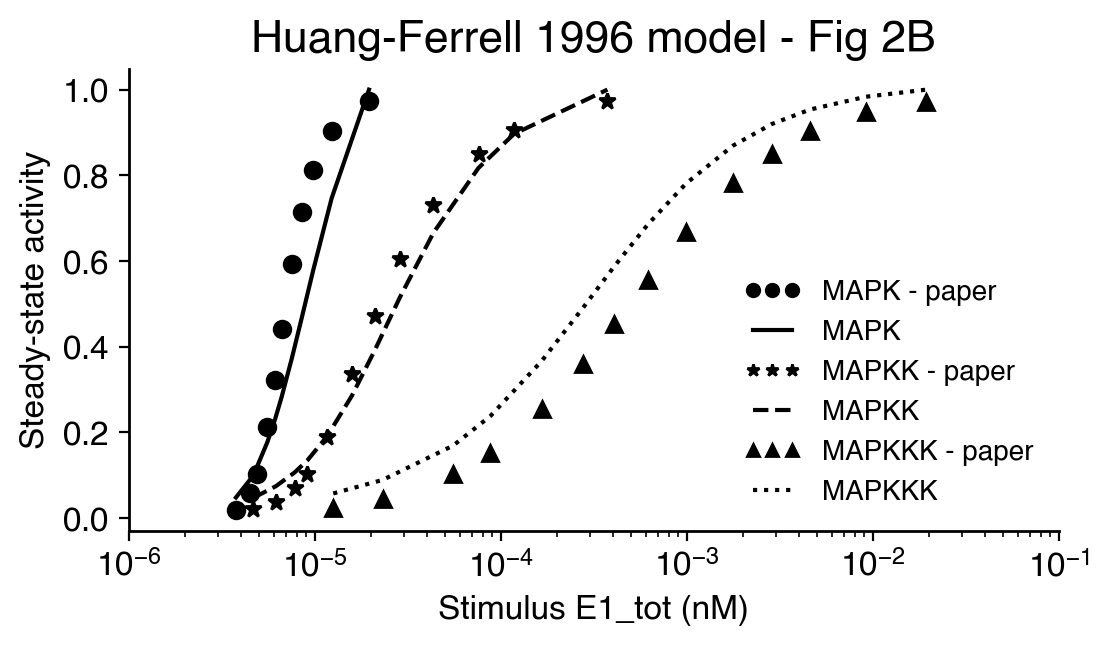

In [5]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(HF_1996_fig2_B_MAPK[:, 0], HF_1996_fig2_B_MAPK[:, 1], 'o', color='k', label='MAPK - paper')
ax.plot(HF_1996_fig2_B_MAPK[:, 0], pred_mapk/pred_mapk[-1],  color='k', label='MAPK')
ax.plot(HF_1996_fig2_B_MAPKK[:, 0], HF_1996_fig2_B_MAPKK[:, 1], '*', color='k', label='MAPKK - paper')
ax.plot(HF_1996_fig2_B_MAPKK[:, 0], pred_mapkk/pred_mapkk[-1],  '--', color='k', label='MAPKK')
ax.plot(HF_1996_fig2_B_MAPKKK[:, 0], HF_1996_fig2_B_MAPKKK[:, 1], '^', color='k', label='MAPKKK - paper')
ax.plot(HF_1996_fig2_B_MAPKKK[:, 0], pred_mapkkk/pred_mapkkk[-1],  ':', color='k', label='MAPKKK')
ax.set_xlabel('Stimulus E1_tot (nM)')
ax.set_ylabel('Steady-state activity')
ax.set_xscale('log')
ax.set_xticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax.legend(fontsize=10)
ax.set_title('Huang-Ferrell 1996 model - Fig 2B')

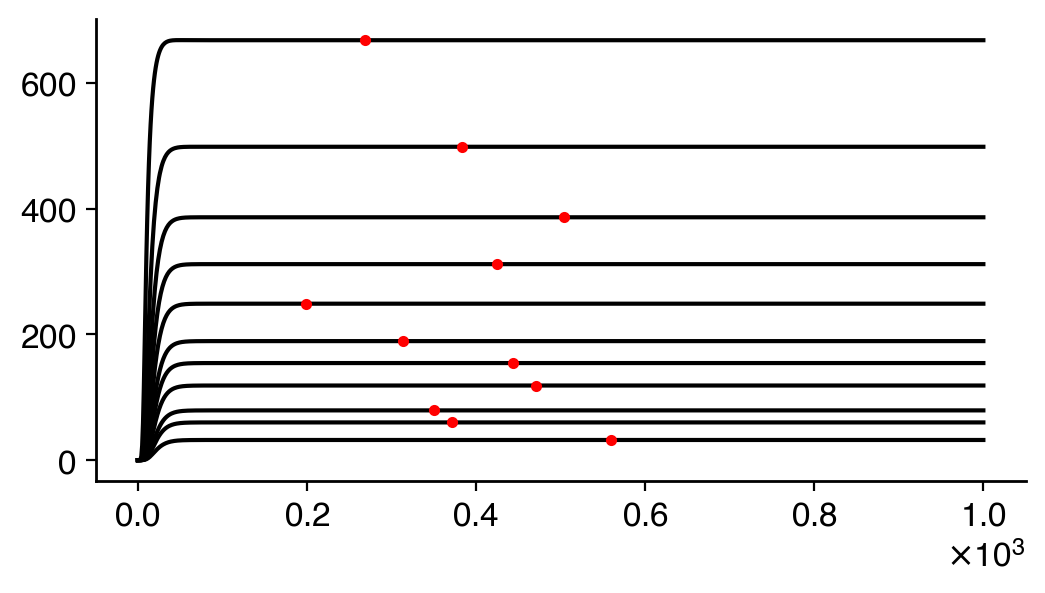

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))

for row in HF_1996_fig2_B_MAPK:
    p_dict, plist = hf_1996.get_nominal_params()
    p_dict['E1_tot'] = row[0]*1e3
    plist = [p_dict[k] for k in p_dict.keys()]
    # run to steady-state
    sol = simulate_model_trajectory(hf_1996, y0, plist, t1=1000)
    
    ax.plot(sol.ts, sol.ys[-1]+sol.ys[-2], color='k')

ax.plot(pred_mapk_times, pred_mapk, '.', color='r')


### Schoeberl 2002

In [7]:
sch_2002 = schoeberl_2002()
y0 = sch_2002.get_initial_conditions()

schoeberl_2002_fig2F_50 = pd.read_csv('./paper_data/schoeberl_2002_fig2F_50.csv').to_numpy()
schoeberl_2002_fig2F_0_5 = pd.read_csv('./paper_data/schoeberl_2002_fig2F_0_5.csv').to_numpy()
schoeberl_2002_fig2F_0_125 = pd.read_csv('./paper_data/schoeberl_2002_fig2F_0_125.csv').to_numpy()

schoeberl_2002_fig2F_50_sim = pd.read_csv('./paper_data/schoeberl_2002_fig2F_50_sim.csv').to_numpy()
schoeberl_2002_fig2F_0_5_sim = pd.read_csv('./paper_data/schoeberl_2002_fig2F_0_5_sim.csv').to_numpy()
schoeberl_2002_fig2F_0_125_sim = pd.read_csv('./paper_data/schoeberl_2002_fig2F_0_125_sim.csv').to_numpy()

In [9]:

sols = []
EGFs = [50, 0.5, 0.125] # ng/ml
multiplier = (1e-18 * 6.022e23) / 6045 # convert ng/ml to molecules/cell (see physiomproject docs)
for EGF in EGFs:
    y0 = sch_2002.get_initial_conditions()
    y0 = list(y0)
    y0[0] = EGF*multiplier
    y0 = tuple(y0)
    _, plist = sch_2002.get_nominal_params()
    sol = simulate_model_trajectory(sch_2002, y0, plist, t1=60)
    sols.append(sol)

Text(0.5, 1.0, 'Schoeberl 2002 model - Fig 2E')

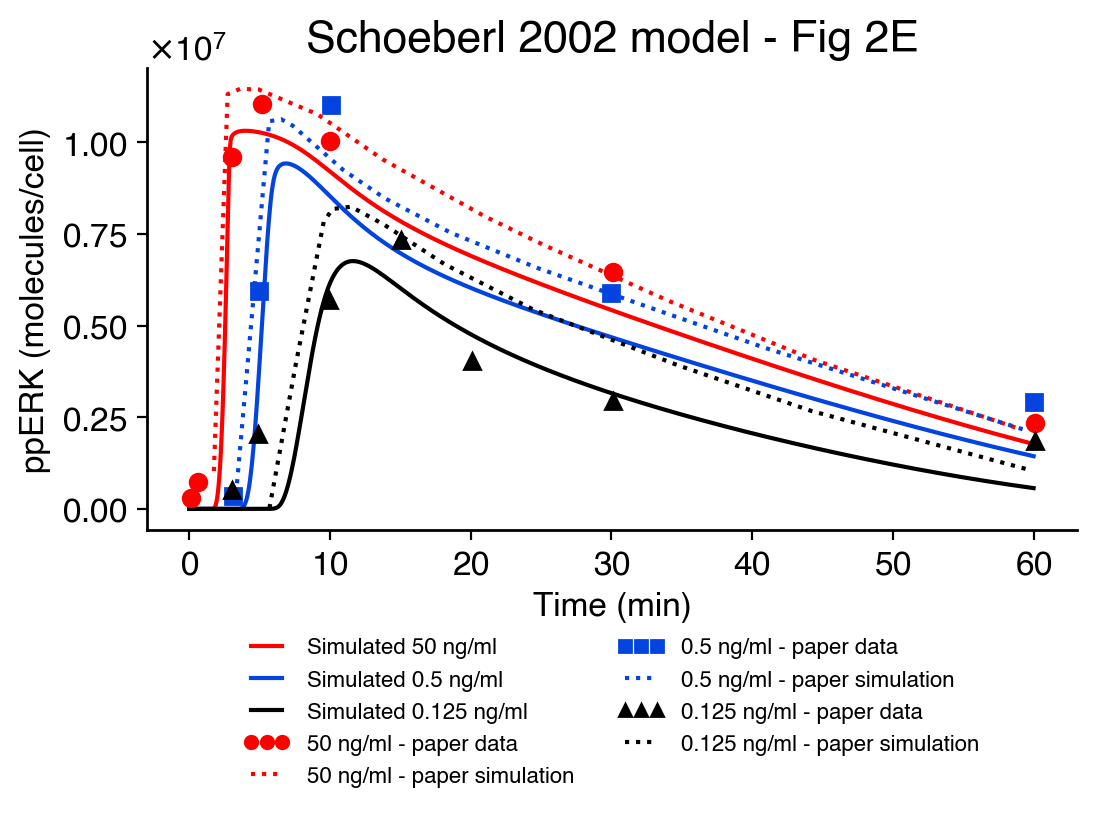

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))

colors = ['r', 'xkcd:blue', 'k']
labels = ['Simulated 50 ng/ml', 'Simulated 0.5 ng/ml', 'Simulated 0.125 ng/ml']
for i, sol in enumerate(sols):
    ax.plot(sol.ts, sol.ys[58]+sol.ys[82], color=colors[i], label=labels[i])

ax.plot(schoeberl_2002_fig2F_50[:,0], schoeberl_2002_fig2F_50[:,1], 'o', color='r', label='50 ng/ml - paper data')
ax.plot(schoeberl_2002_fig2F_50_sim[:,0], schoeberl_2002_fig2F_50_sim[:,1], 'r:', label='50 ng/ml - paper simulation')
ax.plot(schoeberl_2002_fig2F_0_5[:,0], schoeberl_2002_fig2F_0_5[:,1], 's', color='xkcd:blue', label='0.5 ng/ml - paper data')
ax.plot(schoeberl_2002_fig2F_0_5_sim[:,0], schoeberl_2002_fig2F_0_5_sim[:,1], ':', color='xkcd:blue', label='0.5 ng/ml - paper simulation')
ax.plot(schoeberl_2002_fig2F_0_125[:,0], schoeberl_2002_fig2F_0_125[:,1], '^', color='k', label='0.125 ng/ml - paper data')
ax.plot(schoeberl_2002_fig2F_0_125_sim[:,0], schoeberl_2002_fig2F_0_125_sim[:,1], 'k:', label='0.125 ng/ml - paper simulation')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (molecules/cell)')
ax.legend(fontsize=8, ncols=2, bbox_to_anchor=(0.5, -0.6), loc='lower center')
ax.set_title('Schoeberl 2002 model - Fig 2E')

### Brightman and Fell 2000

In [3]:
BF_2000 = brightman_fell_2000()
pdict, plist = BF_2000.get_nominal_params()

(0.0, 60.0)

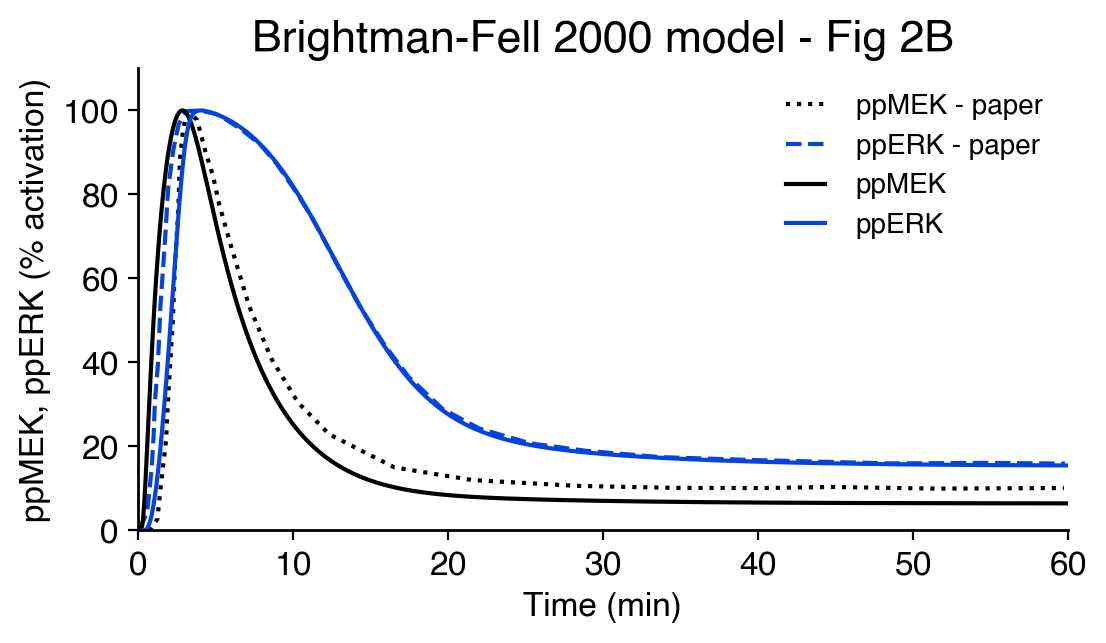

In [9]:
# update EGF to a more reasonable value
# This is 100 nM assuming a cell volume of 1e-9 L
y0 = BF_2000.get_initial_conditions()
y0 = list(y0)
y0[3] = 6.022e7
y0 = tuple(y0)

# run simulation with nominal params
sol = simulate_model_trajectory(BF_2000, y0, plist, t1=60)

# load data
BF_2000_fig2B_MEK = pd.read_csv('./paper_data/brightman_fell_2000_fig2B_MEK.csv').to_numpy()
BF_2000_fig2B_ERK = pd.read_csv('./paper_data/brightman_fell_2000_fig2B_ERK.csv').to_numpy()

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(BF_2000_fig2B_MEK[:, 0], BF_2000_fig2B_MEK[:, 1], ':', color='k', label='ppMEK - paper')
ax.plot(BF_2000_fig2B_ERK[:, 0], BF_2000_fig2B_ERK[:, 1], '--', color='xkcd:blue', label='ppERK - paper')

ax.plot(sol.ts, 100*sol.ys[23]/np.max(sol.ys[23]), color='k', label='ppMEK')
ax.plot(sol.ts, 100*sol.ys[26]/np.max(sol.ys[26]), color='xkcd:blue', label='ppERK')

ax.set_title('Brightman-Fell 2000 model - Fig 2B')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppMEK, ppERK (% activation)')
ax.legend(fontsize=10)
ax.set_ylim([0, 110])
ax.set_xlim([0, 60])


In [ ]:
# state_names = ['Rs', 'RL', 'Ri', 'L', 'R2L2', 'R2_CPP', 'Li', 'R2i', 'Shc', 'ShcP', 'ShcGS', 'GS', 'GSP', 'RasGDP', 'Ras_ShcGS', 'RasGTP', 'GAP', 'Ras_GAP', 'Raf', 'Ras_Raf', 'Rafa', 'MEK', 'MEKP', 'MEKPP', 'ERK', 'ERKP', 'ERKPP']

# for i in range(27):
#     fig, ax = plt.subplots(figsize=(6, 1))
#     ax.plot(sol.ts, sol.ys[i], color='k')
#     ax.set_title(state_names[i])

### Birtwistle 2007

In [3]:
BW_2007 = birtwistle_2007()
pdict, plist = BW_2007.get_nominal_params()
y0dict, y0 = BW_2007.get_initial_conditions()

In [17]:
# run the simulation
EGFs = [0, 0.5, 10]
HRGs = [0.5, 0]
sols = {}
for EGF in EGFs:
    for HRG in HRGs:
        y0dict, y0 = BW_2007.get_initial_conditions()
        y0dict['E'] = EGF
        y0dict['H'] = HRG
        y0 = tuple(y0dict.values())
        # if EGF or HRG:
        sol = simulate_model_trajectory(BW_2007, y0, plist, t1=1800)
        sols[(EGF, HRG)] = sol

        if sol.result > 0:
            print('EGF={}, HRG={} failed'.format(EGF, HRG))
        else:
            print('EGF={}, HRG={} succeeded'.format(EGF, HRG))
        # else:
        #     print('skipping EGF=0, HRG=0')

EGF=0, HRG=0.5 succeeded
EGF=0, HRG=0 succeeded
EGF=0.5, HRG=0.5 succeeded
EGF=0.5, HRG=0 succeeded
EGF=10, HRG=0.5 succeeded
EGF=10, HRG=0 succeeded


In [18]:
# load data from the paper
BW_2007_egf0 = pd.read_csv('./paper_data/birtwistle_2007_fig4A_egf0_data.csv').to_numpy()
BW_2007_egf0_5 = pd.read_csv('./paper_data/birtwistle_2007_fig4A_egf0_5_data.csv').to_numpy()
BW_2007_egf10 = pd.read_csv('./paper_data/birtwistle_2007_fig4A_egf10_data.csv').to_numpy()

# load sims from the paper
BW_2007_solid = pd.read_csv('./paper_data/birtwistle_2007_fig4A_solid_sim.csv').to_numpy()
BW_2007_thick_dash = pd.read_csv('./paper_data/birtwistle_2007_fig4A_thick_dash_sim.csv').to_numpy()
BW_2007_thin_dash = pd.read_csv('./paper_data/birtwistle_2007_fig4A_thin_dash_sim.csv').to_numpy()

In [19]:
dat = np.vstack((sols[(0, 0.5)].ys[75]+sols[(0, 0.5)].ys[115], sols[(0.5, 0.5)].ys[75]+sols[(0.5, 0.5)].ys[115], sols[(10, 0.5)].ys[75]+sols[(10, 0.5)].ys[115], sols[(0.5, 0)].ys[75]+sols[(0.5, 0)].ys[115], sols[(10, 0)].ys[75]+sols[(10, 0)].ys[115]))
dat[dat==np.inf] = np.nan
normalization = np.nanmax(dat)
print(normalization)

566.5918415897825


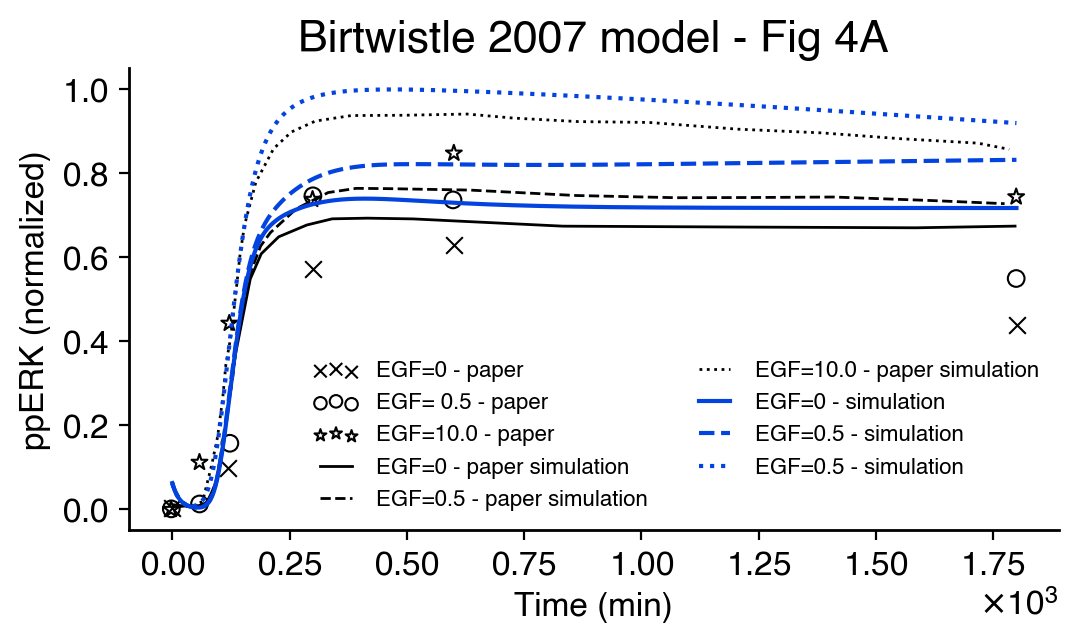

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))

# plot data
ax.scatter(BW_2007_egf0[:, 0], BW_2007_egf0[:, 1], marker='x', color='k', label='EGF=0 - paper', linewidth=0.75)
ax.scatter(BW_2007_egf0_5[:, 0], BW_2007_egf0_5[:, 1], label='EGF= 0.5 - paper', facecolors='none', edgecolor='k', marker='o', linewidth=0.75)
ax.scatter(BW_2007_egf10[:, 0], BW_2007_egf10[:, 1], label='EGF=10.0 - paper', facecolors='none', edgecolor='k', marker='*', linewidth=0.75)

# plot simulations from paper
ax.plot(BW_2007_solid[:, 0], BW_2007_solid[:, 1], color='k', label='EGF=0 - paper simulation', linewidth=1.0)
ax.plot(BW_2007_thick_dash[:, 0], BW_2007_thick_dash[:, 1], '--', color='k', label='EGF=0.5 - paper simulation', linewidth=1.0)
ax.plot(BW_2007_thin_dash[:, 0], BW_2007_thin_dash[:, 1], ':', color='k', label='EGF=10.0 - paper simulation', linewidth=1.0)

# plot simulations
ax.plot(sols[(0, 0.5)].ts, (sols[(0, 0.5)].ys[75]+sols[(0, 0.5)].ys[115])/normalization,'-', color='xkcd:blue', label='EGF=0 - simulation')
ax.plot(sols[(0.5, 0.5)].ts, (sols[(0.5, 0.5)].ys[75]+sols[(0.5, 0.5)].ys[115])/normalization,'--', color='xkcd:blue', label='EGF=0.5 - simulation')
ax.plot(sols[(10, 0.5)].ts, (sols[(10, 0.5)].ys[75]+sols[(10, 0.5)].ys[115])/normalization,':', color='xkcd:blue', label='EGF=10 - simulation')

ax.set_title('Birtwistle 2007 model - Fig 4A')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
ax.legend(fontsize=8, ncol=2)

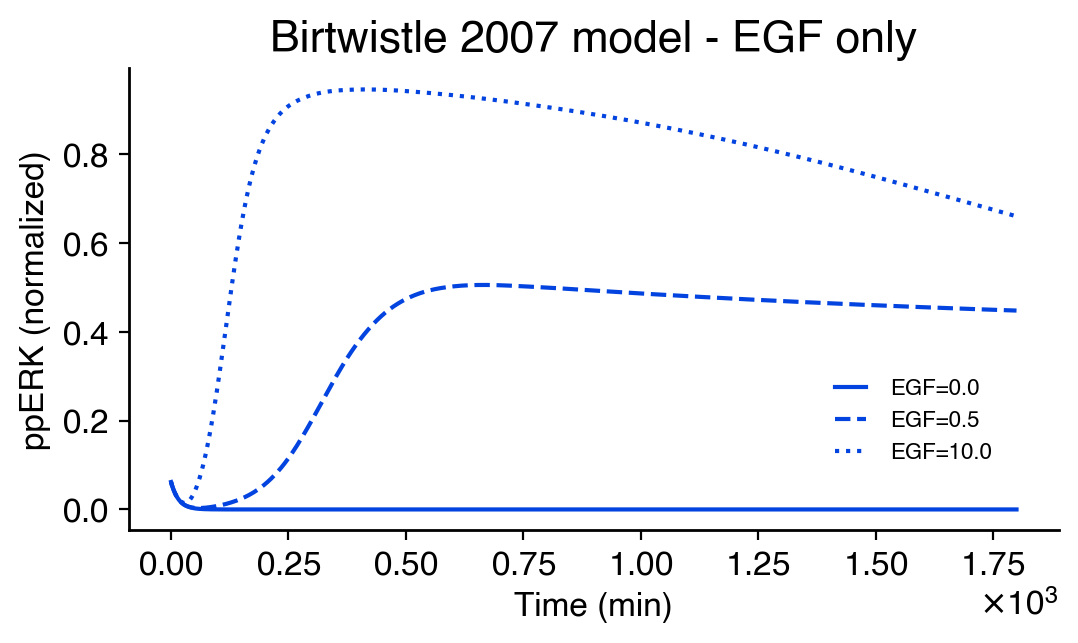

In [30]:
fig, ax = plt.subplots(figsize=(6, 3))

# plot simulations
ax.plot(sols[(0, 0)].ts, (sols[(0, 0)].ys[75]+sols[(0, 0)].ys[115])/normalization,'-', color='xkcd:blue', label='EGF=0.0')
ax.plot(sols[(0.5, 0)].ts, (sols[(0.5, 0)].ys[75]+sols[(0.5, 0)].ys[115])/normalization,'--', color='xkcd:blue', label='EGF=0.5')
ax.plot(sols[(10, 0)].ts, (sols[(10, 0)].ys[75]+sols[(10, 0)].ys[115])/normalization,':', color='xkcd:blue', label='EGF=10.0')

ax.set_title('Birtwistle 2007 model - EGF only')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ppERK (normalized)')
ax.legend(fontsize=8, loc='lower right', bbox_to_anchor=(0.95, 0.1))

In [7]:
for i, name in enumerate(y0dict.keys()):
    if name=='ERKstar':
        print('ERKstar', i)
    elif name=='ERKstar_ERKpase':
        print('ERKstar_ERKpase', i)
    elif name=='E':
        print('E', i)
    elif name=='H':
        print('H', i)

E 0
H 1
ERKstar 75
ERKstar_ERKpase 115


### Hatakeyama 2003

In [26]:
HK_2003 = hatakeyama_2003()
pdict, plist = HK_2003.get_nominal_params()
y0 = HK_2003.get_initial_conditions()

state_names = ['R', 'Shc', 'PI3K', 'HRG', 'R_HRG', 'R_HRG2', 'Internalisation', 'RP', 'R_Shc', 'R_ShP', 'ShP', 'R_ShGS', 'ShGS', 'GS', 'R_PI3K', 'R_PI3Kstar', 'PI3Kstar', 'RasGTP', 'RasGDP', 'Akt_PIPP', 'RAF_star', 'RAF', 'MEKP', 'MEKPP', 'P', 'PIP3', 'Akt', 'Akt_PIP3', 'Akt_PIP', 'MEK', 'ERK', 'ERKP', 'ERKPP']

# load paper data
HK_RAF_star_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4D_thick_dash.csv').to_numpy()
HK_RAF_star_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4D_thin_dash.csv').to_numpy()
HK_RAF_star_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4D_solid.csv').to_numpy()

HK_MEKPP_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_thick_dash.csv').to_numpy()
HK_MEKPP_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_thin_dash.csv').to_numpy()
HK_MEKPP_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_solid.csv').to_numpy()
HK_MEKPP_dat_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_tri_data.csv').to_numpy()
HK_MEKPP_dat_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_circle_data.csv').to_numpy()
HK_MEKPP_dat_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4E_square_data.csv').to_numpy()

HK_ERKPP_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_thick_dash.csv').to_numpy()
HK_ERKPP_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_thin_dash.csv').to_numpy()
HK_ERKPP_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_solid.csv').to_numpy()
HK_ERKPP_dat_0_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_tri_data.csv').to_numpy()
HK_ERKPP_dat_1 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_circle_data.csv').to_numpy()
HK_ERKPP_dat_10 = pd.read_csv('./paper_data/hatakeyama_2003_fig4F_square_data.csv').to_numpy()


In [32]:
# run sims at different HRG concentrations
sols = {}
HRGs = [0.1, 1, 10]
for HRG in HRGs:
    y0 = HK_2003.get_initial_conditions()
    y0 = list(y0)
    y0[3] = HRG*1e2
    y0 = tuple(y0)
    print(y0)
    sol = simulate_model_trajectory(HK_2003, y0, plist, t1=1800)
    sols[HRG] = sol

(80.0, 1000.0, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 120.0, 0.0, 0.0, 100.0, 0.0, 0.0, 800.0, 0.0, 10.0, 0.0, 0.0, 120.0, 1000.0, 0.0, 0.0)
(80.0, 1000.0, 10.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 120.0, 0.0, 0.0, 100.0, 0.0, 0.0, 800.0, 0.0, 10.0, 0.0, 0.0, 120.0, 1000.0, 0.0, 0.0)
(80.0, 1000.0, 10.0, 1000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 120.0, 0.0, 0.0, 100.0, 0.0, 0.0, 800.0, 0.0, 10.0, 0.0, 0.0, 120.0, 1000.0, 0.0, 0.0)


(0.0, 95.0)

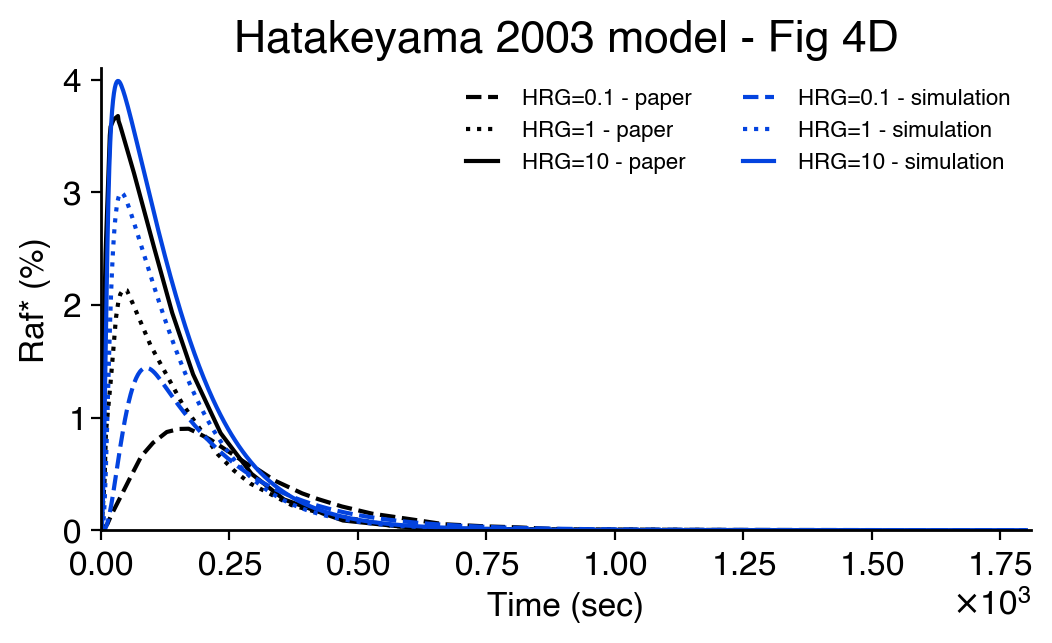

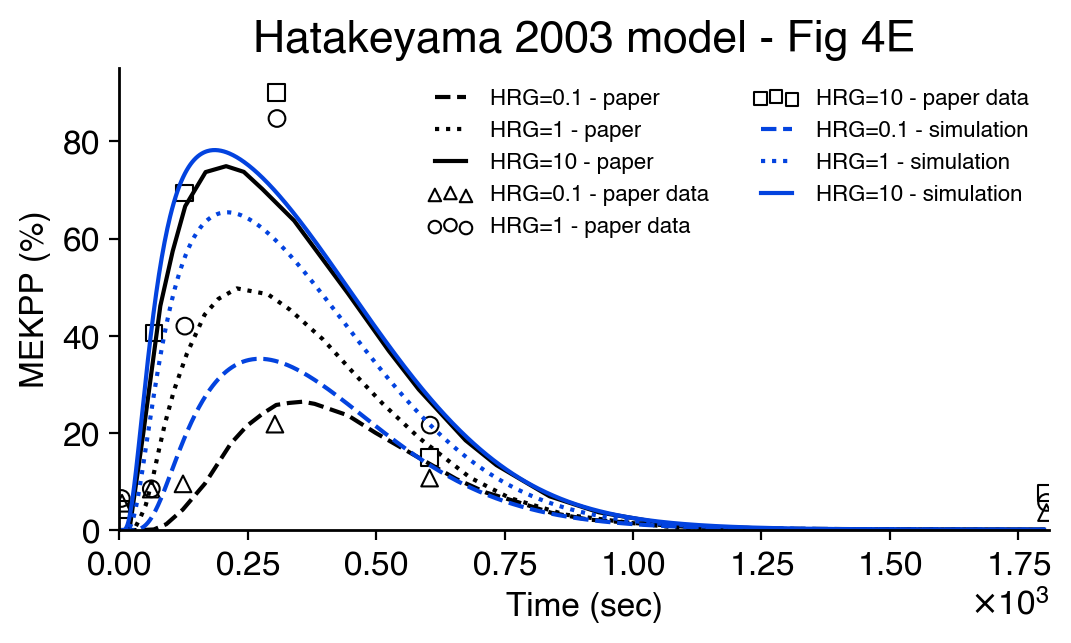

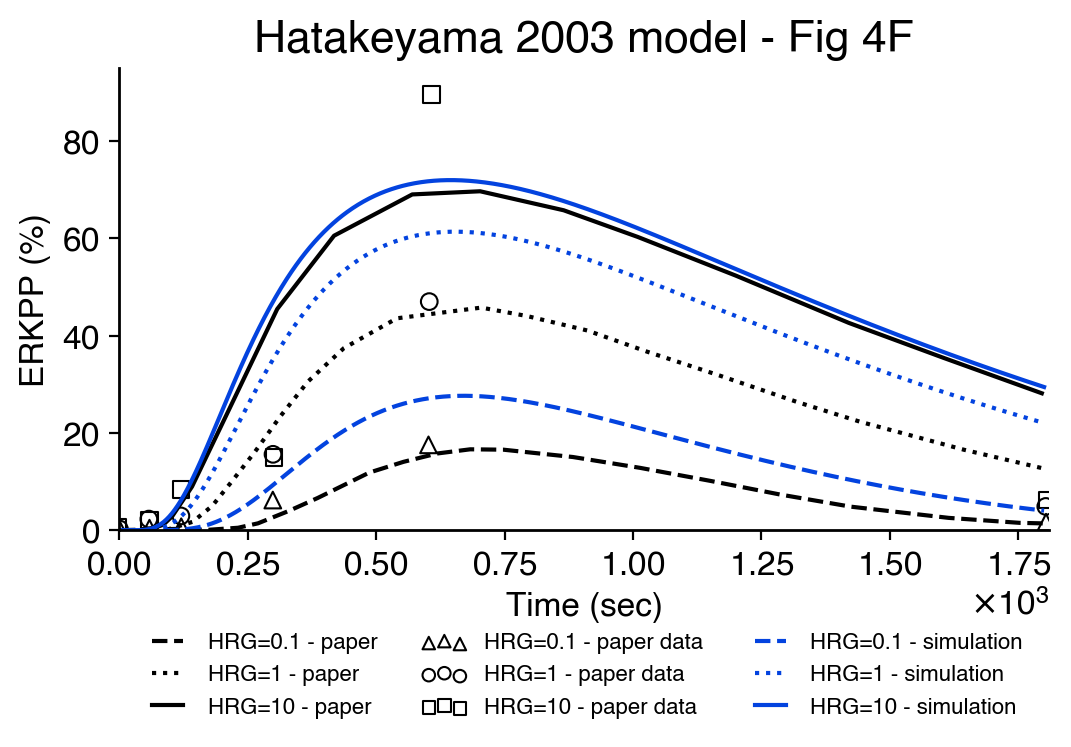

In [67]:
# Raf_star
fig, ax = plt.subplots(figsize=(6, 3))
# sims from the paper
ax.plot(HK_RAF_star_0_1[:, 0], HK_RAF_star_0_1[:, 1], '--', color='k', label='HRG=0.1 - paper')
ax.plot(HK_RAF_star_1[:, 0], HK_RAF_star_1[:, 1], ':', color='k', label='HRG=1 - paper')
ax.plot(HK_RAF_star_10[:, 0], HK_RAF_star_10[:, 1], '-', color='k', label='HRG=10 - paper')

# sims from this model
ax.plot(sols[0.1].ts, sols[0.1].ys[20], '--', color='xkcd:blue', label='HRG=0.1 - simulation')
ax.plot(sols[1].ts, sols[1].ys[20], ':', color='xkcd:blue', label='HRG=1 - simulation')
ax.plot(sols[10].ts, sols[10].ys[20], '-', color='xkcd:blue', label='HRG=10 - simulation')

ax.set_title('Hatakeyama 2003 model - Fig 4D')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Raf* (%)')
ax.legend(fontsize=8, ncol=2)
ax.set_xlim([0, 1810])
ax.set_ylim([0, 4.1])




# MEKPP
fig, ax = plt.subplots(figsize=(6, 3))
# sims from the paper
ax.plot(HK_MEKPP_0_1[:, 0], HK_MEKPP_0_1[:, 1], '--', color='k', label='HRG=0.1 - paper')
ax.plot(HK_MEKPP_1[:, 0], HK_MEKPP_1[:, 1], ':', color='k', label='HRG=1 - paper')
ax.plot(HK_MEKPP_10[:, 0], HK_MEKPP_10[:, 1], '-', color='k', label='HRG=10 - paper')
# data
ax.scatter(HK_MEKPP_dat_0_1[:, 0], HK_MEKPP_dat_0_1[:, 1], marker='^', color='k', label='HRG=0.1 - paper data', facecolors='none', linewidth=0.75)
ax.scatter(HK_MEKPP_dat_1[:, 0], HK_MEKPP_dat_1[:, 1], marker='o', color='k', label='HRG=1 - paper data', facecolors='none', linewidth=0.75,)
ax.scatter(HK_MEKPP_dat_10[:, 0], HK_MEKPP_dat_10[:, 1], marker='s', color='k', label='HRG=10 - paper data', facecolors='none', linewidth=0.75,)

# sims from this model
ax.plot(sols[0.1].ts, 100*sols[0.1].ys[23]/120, '--', color='xkcd:blue', label='HRG=0.1 - simulation')
ax.plot(sols[1].ts, 100*sols[1].ys[23]/120, ':', color='xkcd:blue', label='HRG=1 - simulation')
ax.plot(sols[10].ts, 100*sols[10].ys[23]/120, '-', color='xkcd:blue', label='HRG=10 - simulation')

ax.set_title('Hatakeyama 2003 model - Fig 4E')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('MEKPP (%)')
ax.legend(fontsize=8, ncol=2)
ax.set_xlim([0, 1810])
ax.set_ylim([0, 95])


# ERKPP
fig, ax = plt.subplots(figsize=(6, 3))
# sims from the paper
ax.plot(HK_ERKPP_0_1[:, 0], HK_ERKPP_0_1[:, 1], '--', color='k', label='HRG=0.1 - paper')
ax.plot(HK_ERKPP_1[:, 0], HK_ERKPP_1[:, 1], ':', color='k', label='HRG=1 - paper')
ax.plot(HK_ERKPP_10[:, 0], HK_ERKPP_10[:, 1], '-', color='k', label='HRG=10 - paper')
# data
ax.scatter(HK_ERKPP_dat_0_1[:, 0], HK_ERKPP_dat_0_1[:, 1], marker='^', color='k', label='HRG=0.1 - paper data', facecolors='none', linewidth=0.75)
ax.scatter(HK_ERKPP_dat_1[:, 0], HK_ERKPP_dat_1[:, 1], marker='o', color='k', label='HRG=1 - paper data', facecolors='none', linewidth=0.75,)
ax.scatter(HK_ERKPP_dat_10[:, 0], HK_ERKPP_dat_10[:, 1], marker='s', color='k', label='HRG=10 - paper data', facecolors='none', linewidth=0.75,)

# sims from this model
ax.plot(sols[0.1].ts, 100*sols[0.1].ys[32]/1000, '--', color='xkcd:blue', label='HRG=0.1 - simulation')
ax.plot(sols[1].ts, 100*sols[1].ys[32]/1000, ':', color='xkcd:blue', label='HRG=1 - simulation')
ax.plot(sols[10].ts, 100*sols[10].ys[32]/1000, '-', color='xkcd:blue', label='HRG=10 - simulation')

ax.set_title('Hatakeyama 2003 model - Fig 4F')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('ERKPP (%)')
ax.legend(fontsize=8, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.45))
ax.set_xlim([0, 1810])
ax.set_ylim([0, 95])


### Hornberg 2005

In [53]:
HB_2005 = hornberg_2005()
pdict, plist = HB_2005.get_nominal_params()
y0 = HB_2005.get_initial_conditions()

sol = simulate_model_trajectory(HB_2005, y0, plist, t1=6000)

# load paper data
HB_2005_fig2_ERKpp = pd.read_csv('./paper_data/hornberg_2005_fig2.csv').to_numpy()

(0.0, 12000000.0)

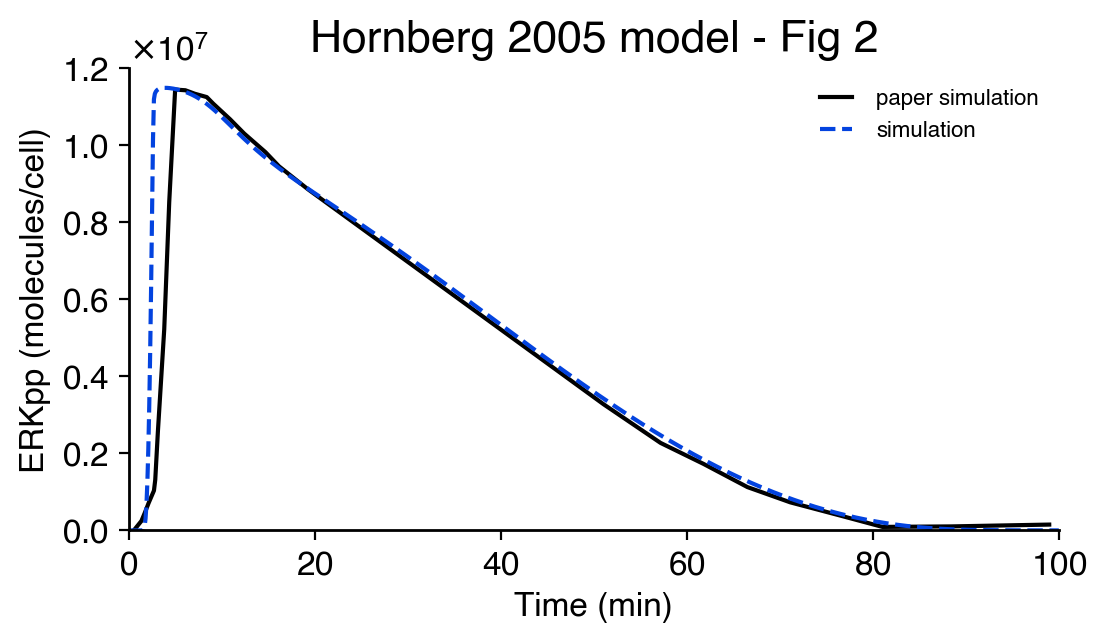

In [65]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(HB_2005_fig2_ERKpp[:, 0], HB_2005_fig2_ERKpp[:, 1], '-', color='k', label='paper simulation')
ax.plot(sol.ts/60, sol.ys[58]+sol.ys[82], '--', color='xkcd:blue', label='simulation')
ax.set_title('Hornberg 2005 model - Fig 2')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ERKpp (molecules/cell)')
ax.legend(fontsize=8)
ax.set_xlim([0, 100])
ax.set_ylim([0, 1.2e7])

### Shin 2014

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_63602/2392502400.py:33: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])


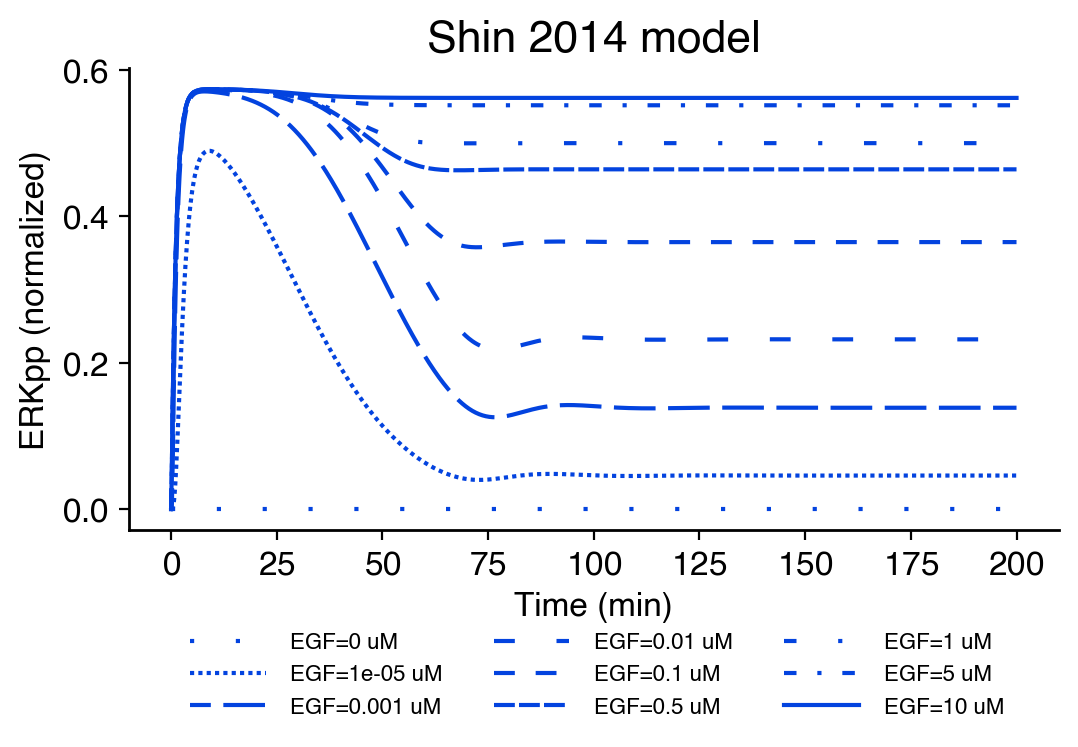

In [115]:
SN_2014 = shin_2014()
pdict, plist = SN_2014.get_nominal_params()
y0 = SN_2014.get_initial_conditions()

sols = {}
cols = ['xkcd:blue', 'xkcd:black', 'xkcd:indigo', 'xkcd:red', 'xkcd:gray', 'xkcd:brown', 'xkcd:pink', 'xkcd:gray', 'xkcd:dark yellow']

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     # ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     # ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('', '-'),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

EGFs = [0, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 1, 5, 10]
fig, ax = plt.subplots(figsize=(6, 3))
for i, EGF in enumerate(EGFs):
    pdict, plist = SN_2014.get_nominal_params()
    plist[-1] = EGF
    sol = simulate_model_trajectory(SN_2014, y0, plist, t1=200)
    sols[EGF] = sol

    ax.plot(sol.ts, sol.ys[-1]/pdict['ERK_tot'], '-', color='xkcd:blue', label='EGF={} uM'.format(EGF), linestyle=linestyle_tuple[i][1])
    ax.set_title('Shin 2014 model')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('ERKpp (normalized)')
    ax.legend(fontsize=8, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.45), handlelength=4)

In [121]:
@jax.jit
def solve_ss(model_dfrx_ode, y0, params, t1=300):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values."""
    dt0=1e-3
    event_rtol=1e-6
    event_atol=1e-6
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0
    dt0 = 1e-3

    sol = diffrax.diffeqsolve(
        model_dfrx_ode, 
        solver, 
        t0, t1, dt0, 
        y0, 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=tuple(list(params)),
        max_steps=None,
        throw=False,)
    
    return jnp.array(sol.ys)

plist = np.array(plist)
ps = np.array([0.75*plist, plist, 1.125*plist])
ps.shape


vsolve_ss = jax.jit(jax.vmap(solve_ss, in_axes=(None, None, 0)))

ss_sols = vsolve_ss(diffrax.ODETerm(SN_2014), y0, ps)

(3, 6, 1)